In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

import altair as alt
from altair.vega import v5
from IPython.display import HTML
from sklearn import preprocessing
from tqdm.notebook import tqdm
import lightgbm as lgb
import numpy as np
import pandas as pd
import lightgbm as lgb
import glob
import os
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from tqdm.notebook import tqdm
import optuna

import gc, datetime, random

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from collections import defaultdict, Counter

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

# helper funcs

In [2]:

def reduce_mem(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def reduce_mem_usage(df, verbose=False):
    return reduce_mem(df, verbose=verbose)


In [3]:
def preprocess1(df, train_flag):
#     cat_cols = cat_cols
    cat_cols = ['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat']
    cate_cols = cat_cols
    feature_key = cat_cols
    feature_target = cat_cols
    for f in tqdm(cate_cols):
        map_dict = dict(zip(df[f].unique(), range(df[f].nunique())))
        df[f + '_count'] = df[f].map(df[f].value_counts())
    df = reduce_mem(df)
    ##########################groupby feature#######################
    def group_fea(df,key,target):
        tmp = df.groupby(key, as_index=False)[target].agg({
            key+'_'+target + '_nunique': 'nunique',
        }).reset_index()
        del tmp['index']
        return tmp

    for key in tqdm(feature_key):
        for target in feature_target:
            tmp = group_fea(df,key,target)
            df = df.merge(tmp,on=key,how='left')
            
            
    #统计做了groupby特征的特征
    group_list = []
    for s in df.columns:
        if '_nunique' in s:
            group_list.append(s)
    #print(group_list)
    return df, group_list

def preprocess(train_df, test_df, num_clusters=10):

    cat_cols = ['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat']
    enc_list=[]
    
    
    
#     test_df, _ = preprocess1(test_df, 0)
#     train_df, group_list = preprocess1(train_df.copy(), 1)
    
#     skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=2020)
#     enc_list = group_list + cat_cols
    
#     for f in tqdm(enc_list):
#         if len(train_df[f].unique()) > len(train_df)//100:
#             print("f ", f)
#             continue
#         train_df[f + '_target_enc'] = 0
#         test_df[f + '_target_enc'] = 0
#         for i, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
#             trn_x = train_df[[f, 'label']].iloc[trn_idx].reset_index(drop=True)
#             val_x = train_df[[f]].iloc[val_idx].reset_index(drop=True)
#             enc_df = trn_x.groupby(f, as_index=False)['label'].agg({f + '_target_enc': 'mean'})
#             val_x = val_x.merge(enc_df, on=f, how='left')
#             test_x = test_df[[f]].merge(enc_df, on=f, how='left')
#             val_x[f + '_target_enc'] = val_x[f + '_target_enc'].fillna(train_df['label'].mean())
#             test_x[f + '_target_enc'] = test_x[f + '_target_enc'].fillna(train_df['label'].mean())
#             train_df.loc[val_idx, f + '_target_enc'] = val_x[f + '_target_enc'].values
#             test_df[f + '_target_enc'] += test_x[f + '_target_enc'].values / skf.n_splits
#             gc.collect()
#         gc.collect()
        
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True), enc_list


In [4]:
train = pd.read_csv("/kaggle/input/job-a-thon-rw/train_Df64byy.csv")
test = pd.read_csv("/kaggle/input/job-a-thon-rw/test_YCcRUnU.csv")
sub = pd.read_csv("/kaggle/input/job-a-thon-rw/sample_submission_QrCyCoT.csv")
sub['ID'] = test['ID']


train = train.fillna(-1)
test = test.fillna(-1)


train = train.drop(['ID'], axis=1)
test = test.drop(['ID'], axis=1)

train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,C5,1117,Owned,Joint,75,22,No,X2,-1,-1.0,22,30510.0,0
2,C5,3732,Owned,Individual,32,32,No,-1,1.0,1.0,19,7450.0,1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [5]:
nn = [
# 'ID',
 'City_Code',
 'Region_Code',
 'Accomodation_Type',
 'Reco_Insurance_Type',
 'Upper_Age',
 'Lower_Age',
 'Is_Spouse',
 'Health Indicator',
 'Holding_Policy_Duration',
 'Holding_Policy_Type',
 'Reco_Policy_Cat',
 'Reco_Policy_Premium',
 'label']

target = 'label'
train.columns = nn


In [6]:
cat_cols = ['City_Code',
 'Region_Code',
 'Accomodation_Type',
 'Reco_Insurance_Type',
 'Is_Spouse',
 'Health Indicator',
 'Holding_Policy_Duration',
 'Holding_Policy_Type',
 'Reco_Policy_Cat']

cat_cols = ['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat']

In [7]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc.fit(np.array(train['Reco_Policy_Cat']).reshape(-1, 1))
df_tr = pd.DataFrame(enc.transform(np.array(train['Reco_Policy_Cat']).reshape(-1, 1)))
df_tes = pd.DataFrame(enc.transform(np.array(test['Reco_Policy_Cat']).reshape(-1, 1)))
tr_col = []
for i in df_tr.columns:
    tr_col.append("OH_" + str(i))
df_tr.columns = tr_col

tr_col = []
for i in df_tes.columns:
    tr_col.append("OH_" + str(i))
df_tes.columns = tr_col


train = pd.concat([train, df_tr], axis=1)
test = pd.concat([test, df_tes], axis=1)
train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,...,OH_12,OH_13,OH_14,OH_15,OH_16,OH_17,OH_18,OH_19,OH_20,OH_21
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,C5,1117,Owned,Joint,75,22,No,X2,-1,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,C5,3732,Owned,Individual,32,32,No,-1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


4058    1483.790646
3789    1167.032517
3890    1167.032517
4102    1167.032517
4364    1167.032517
           ...     
4509     216.758129
4533     216.758129
4542     216.758129
4550     216.758129
4559     216.758129
Length: 500, dtype: float64

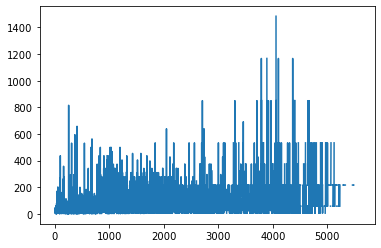

In [8]:
i='Region_Code'
xx = train[target].value_counts()[0] / train[target].value_counts()[1] 
df = pd.DataFrame({0 : train[train[target]==0][i].value_counts()/xx, 1: train[train[target]==1][i].value_counts()})
plt.plot(np.abs((df[0]-df[1] )/df.min(axis=1))*100)

((np.abs((df[0]-df[1] )/df.min(axis=1))*100).sort_values(ascending=False)[:500])


['City_Code',
 'Region_Code',
 'Accomodation_Type',
 'Reco_Insurance_Type',
 'Upper_Age',
 'Lower_Age',
 'Is_Spouse',
 'Health Indicator',
 'Holding_Policy_Duration',
 'Holding_Policy_Type',
 'Reco_Policy_Cat',
 'Region_Code_limited']

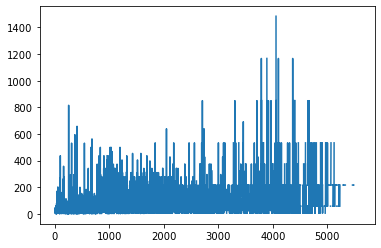

In [9]:
i='Region_Code'
xx = train[target].value_counts()[0] / train[target].value_counts()[1] 
df = pd.DataFrame({0 : train[train[target]==0][i].value_counts()/xx, 1: train[train[target]==1][i].value_counts()})
plt.plot(np.abs((df[0]-df[1] )/df.min(axis=1))*100)

idx = list((np.abs((df[0]-df[1] )/df.min(axis=1))*100).sort_values(ascending=False)[:500].index)

train['Region_Code_limited'] = train['Region_Code']
train['Region_Code_limited']
for j in train['Region_Code_limited'].index:
    if train['Region_Code_limited'][j] in idx:
        continue
    else :
        train['Region_Code_limited'][j] = -1
        
        
test['Region_Code_limited'] = test['Region_Code']
test['Region_Code_limited']
for j in test['Region_Code_limited'].index:
    if test['Region_Code_limited'][j] in idx:
        continue
    else :
        test['Region_Code_limited'][j] = -1
        
        
cat_cols.append('Region_Code_limited')
cat_cols

In [10]:
# train['Region_Code_limited'].value_counts()

# balaced check

In [11]:
# train['Response'].value_counts()

In [12]:
# train1 = train[train['Response'] == 1]
# train = pd.concat([train, train1], axis=0).reset_index(drop=True)
# train = pd.concat([train, train1], axis=0).reset_index(drop=True)
# 

In [13]:
# train['Response'].value_counts()

In [14]:
# for i in train.columns:
#     print(i,  len(train[i].unique()))

In [15]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,...,OH_13,OH_14,OH_15,OH_16,OH_17,OH_18,OH_19,OH_20,OH_21,Region_Code_limited
0,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
1,C5,1117,Owned,Joint,75,22,No,X2,-1,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1
2,C5,3732,Owned,Individual,32,32,No,-1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1
3,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


# H2O

In [16]:
!pip install h2o

In [17]:
import sys, os, os.path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle

import h2o
from h2o.automl import H2OAutoML

h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=12  # in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpolj1dx_c
  JVM stdout: /tmp/tmpolj1dx_c/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpolj1dx_c/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_2c19br
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [18]:
X_train = train.drop([target], axis=1)
X_test = test.copy()
y_train = train[target]

In [19]:
xx = list(X_train.columns)
feature_cols = []
for i in xx:
    if i not in cat_cols:
        feature_cols.append(i)
feature_cols

['Reco_Policy_Premium',
 'OH_0',
 'OH_1',
 'OH_2',
 'OH_3',
 'OH_4',
 'OH_5',
 'OH_6',
 'OH_7',
 'OH_8',
 'OH_9',
 'OH_10',
 'OH_11',
 'OH_12',
 'OH_13',
 'OH_14',
 'OH_15',
 'OH_16',
 'OH_17',
 'OH_18',
 'OH_19',
 'OH_20',
 'OH_21']

In [20]:
for feat in cat_cols:
    X_train[feat] = X_train[feat].astype('category')
    X_test[feat] = X_test[feat].astype('category')

In [21]:
# metalearner.predict(X_test_h)

In [22]:
X_y_train_h = h2o.H2OFrame(pd.concat([X_train, y_train], axis='columns'))
X_y_train_h[target] = X_y_train_h[target].asfactor()
# ^ the target column should have categorical type for classification tasks
#   (numerical type for regression tasks)

X_test_h = h2o.H2OFrame(X_test)

X_y_train_h.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:50882
Cols:36




,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,OH_0,OH_1,OH_2,OH_3,OH_4,OH_5,OH_6,OH_7,OH_8,OH_9,OH_10,OH_11,OH_12,OH_13,OH_14,OH_15,OH_16,OH_17,OH_18,OH_19,OH_20,OH_21,Region_Code_limited,label
type,enum,int,enum,enum,int,int,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,,1.0,,,18.0,16.0,,,-1.0,-1.0,1.0,2280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,
mean,,1732.7887072049025,,,44.8562753036436,42.738866396761246,,,2.2195200549981715,1.0704178294878333,15.115188082229473,14183.935615738406,0.038658071616681736,0.03767540584096537,0.020812861129672577,0.019948115247042177,0.019790888722927558,0.016724971502692504,0.01639086513894894,0.015250972839117959,0.015506465940804213,0.015133052946031995,0.015349239416689595,0.04260838803506151,0.03309618332612712,0.0342360756259581,0.03174010455563853,0.08026414056051256,0.07381785307181321,0.10913486105105931,0.0728744939271255,0.06243858338901773,0.09879721709052317,0.1297511890255886,168.26950591564747,
maxs,,6194.0,,,75.0,75.0,,,14.0,4.0,22.0,43360.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5580.0,
sigma,,1424.0816515674207,,,17.31027109474683,17.319375214013107,,,3.7949158980043656,1.8621690181379078,6.340662671839652,6590.038314922004,0.1927805890601181,0.19041187515409508,0.14275884027806926,0.1398233606329658,0.13928241350853088,0.12824028244238803,0.12697449169005734,0.12255070719238305,0.12355693217519578,0.12208331816507043,0.12293875428438852,0.20197454056357633,0.1788895047510076,0.18183678555516156,0.17530908227805214,0.2717043598700611,0.26147680841567544,0.31181140770445887,0.2599329335440343,0.24195279957302385,0.29839248797365675,0.33603279183116436,716.9087674171794,
zeros,,0,,,0,0,,,0,0,0,0,48915,48965,49823,49867,49875,50031,50048,50106,50093,50112,50101,48714,49198,49140,49267,46798,47126,45329,47174,47705,45855,44280,0,
missing,0,0,0,0,0,0,0,0,4335,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,C3,3213.0,Rented,Individual,36.0,36.0,No,X1,nan,3.0,22.0,11632.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0
1,C5,1117.0,Owned,Joint,75.0,22.0,No,X2,-1.0,-1.0,22.0,30512.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0
2,C5,3732.0,Owned,Individual,32.0,32.0,No,-1,1.0,1.0,19.0,7448.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,1


In [23]:
!mkdir h20_models

In [24]:
!ls

__notebook__.ipynb  h20_models


In [25]:
aml = H2OAutoML(
    max_runtime_secs=(60* 3),  # 3 mins
    max_models=None,  # no limit
    seed=17
)

In [26]:
%%time

aml.train(
    x=feature_cols+cat_cols,
    y='label',
    training_frame=X_y_train_h
)

lb = aml.leaderboard
model_ids = list(lb['model_id'].as_data_frame().iloc[:,0])
out_path = "h20_models"

for m_id in model_ids:
    mdl = h2o.get_model(m_id)
    h2o.save_model(model=mdl, path=out_path, force=True)

h2o.export_file(lb, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%
CPU times: user 26.4 s, sys: 647 ms, total: 27 s
Wall time: 3min 13s


In [27]:
!ls

__notebook__.ipynb  h20_models


In [28]:

models_path = "../working/h20_models/"

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))

lb.head(rows=10)
#lb.head(rows=lb.nrows)
# ^ to see the entire leaderboard

Parse progress: |█████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210301_040642,0.690324,0.509391,0.407775,0.370287,0.409349,0.167566
StackedEnsemble_BestOfFamily_AutoML_20210301_040642,0.685695,0.510996,0.405054,0.372912,0.410012,0.16811
GBM_grid__1_AutoML_20210301_040642_model_1,0.676132,0.512388,0.398041,0.382059,0.411065,0.168974
XGBoost_grid__1_AutoML_20210301_040642_model_2,0.670844,0.515267,0.384218,0.382,0.412839,0.170436
XGBoost_grid__1_AutoML_20210301_040642_model_1,0.66965,0.517795,0.380826,0.383861,0.414081,0.171463
GBM_5_AutoML_20210301_040642,0.667254,0.533148,0.380241,0.38897,0.419274,0.175791
GBM_grid__1_AutoML_20210301_040642_model_2,0.658477,0.525069,0.373837,0.392106,0.415758,0.172855
GBM_3_AutoML_20210301_040642,0.655723,0.532094,0.377601,0.39845,0.418794,0.175389
GBM_4_AutoML_20210301_040642,0.654477,0.532204,0.376455,0.408351,0.418762,0.175362
GBM_2_AutoML_20210301_040642,0.642136,0.535295,0.364921,0.416248,0.420285,0.17664


In [29]:
se_all = h2o.load_model(os.path.join(models_path, str(lb['model_id'].get_frame_data().split('\n')[1][1:-1])))
# Get the Stacked Ensemble metalearner model



# metalearner = h2o.get_model(se_all.metalearner()['name'])
metalearner = h2o.get_model(se_all.metalearner().model_id)

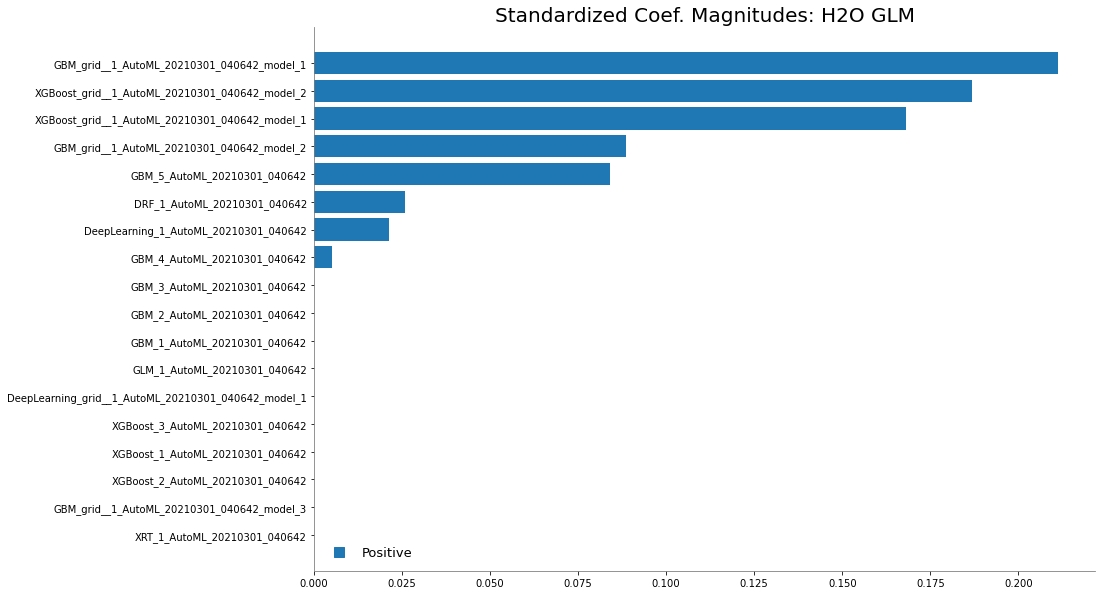

In [30]:
%matplotlib inline
metalearner.std_coef_plot(num_of_features=20)
# ^ all importance values starting from the 16th are zero

#metalearner.coef_norm()
# ^ to see the table in the text form

In [31]:
from IPython.display import FileLinks

FileLinks('.')

./
  __notebook__.ipynb
./h20_models/
  XRT_1_AutoML_20210301_040642
  aml_leaderboard.h2o
  GBM_grid__1_AutoML_20210301_040642_model_1
  XGBoost_grid__1_AutoML_20210301_040642_model_2
  DeepLearning_1_AutoML_20210301_040642
  XGBoost_3_AutoML_20210301_040642
  DRF_1_AutoML_20210301_040642
  GBM_1_AutoML_20210301_040642
  XGBoost_1_AutoML_20210301_040642
  GBM_grid__1_AutoML_20210301_040642_model_2
  DeepLearning_grid__1_AutoML_20210301_040642_model_1
  GBM_5_AutoML_20210301_040642
  StackedEnsemble_AllModels_AutoML_20210301_040642
  GLM_1_AutoML_20210301_040642
  GBM_grid__1_AutoML_20210301_040642_model_3
  GBM_2_AutoML_20210301_040642
  GBM_4_AutoML_20210301_040642
  XGBoost_grid__1_AutoML_20210301_040642_model_1
  XGBoost_2_AutoML_20210301_040642
  GBM_3_AutoML_20210301_040642
  StackedEnsemble_BestOfFamily_AutoML_20210301_040642

In [32]:
metalearner.auc()

0.6909156967972314

In [33]:
X_test_h['label'] = 0

In [34]:
y_pred = metalearner.predict(X_test_h)['p1']
y_pred = y_pred.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


In [35]:
sub['Response'] = y_pred
sub.to_csv('sub_job_a_thon.csv', index=False)
sub.head()

,ID,Response
0,50883,0.222474
1,50884,0.222474
2,50885,0.222474
3,50886,0.222474
4,50887,0.222474


In [36]:
from IPython.display import FileLinks
FileLinks('.')

./
  __notebook__.ipynb
  sub_job_a_thon.csv
./h20_models/
  XRT_1_AutoML_20210301_040642
  aml_leaderboard.h2o
  GBM_grid__1_AutoML_20210301_040642_model_1
  XGBoost_grid__1_AutoML_20210301_040642_model_2
  DeepLearning_1_AutoML_20210301_040642
  XGBoost_3_AutoML_20210301_040642
  DRF_1_AutoML_20210301_040642
  GBM_1_AutoML_20210301_040642
  XGBoost_1_AutoML_20210301_040642
  GBM_grid__1_AutoML_20210301_040642_model_2
  DeepLearning_grid__1_AutoML_20210301_040642_model_1
  GBM_5_AutoML_20210301_040642
  StackedEnsemble_AllModels_AutoML_20210301_040642
  GLM_1_AutoML_20210301_040642
  GBM_grid__1_AutoML_20210301_040642_model_3
  GBM_2_AutoML_20210301_040642
  GBM_4_AutoML_20210301_040642
  XGBoost_grid__1_AutoML_20210301_040642_model_1
  XGBoost_2_AutoML_20210301_040642
  GBM_3_AutoML_20210301_040642
  StackedEnsemble_BestOfFamily_AutoML_20210301_040642